# Selección de atributos

Es el proceso en el que manualmente o automáticamente se seleccionan los atributos que más afectan a la variable objetivo. Es decir, es un proceso en el que se minimiza el número de atributos intentando optimizar al máximo el rendimiento del modelo.

## Lectura de datos

En este caso utilizaremos el dataset de diabetes de scikit learn para hacer los ejercicios de selección de atributos. Este es un dataset donde la variable objetivo es un valor continuo, es decir, estamos ante un problema de regresión.

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

Estos son los datos que tiene este dataset:

In [2]:
data = load_diabetes()
data_df = pd.DataFrame(data.data, columns=data.feature_names)
data_df['diabetes'] = data.target
data_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetes
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Separamos los datos y la variable objetivo.

In [3]:
X = data_df.drop('diabetes', axis=1)
y = data_df['diabetes']

## Wrapper

Utilizan el rendimiento de los algoritmos de aprendizaje automático para saber si un atributo tiene que estar en el modelo o no. Es decir, este tipo de método introduce los atributos en el algoritmo de aprendizaje automático y dependiendo del rendimiento del modelo va metiendo o eliminando atributos.

Se puede decir que estos métodos son computacionalmente costosos pero suelen ser más precisos que los de tipo filter por ejemplo. 

Hay muchos métodos diferentes dentro de esta categoría: Backward Elimination, Forward Selection, Bidirectional Elimination y RFE.

En este caso analizaremos el Backward Elimination y el RFE.


### Backward Elimination

Al principio introducimos al modelo todos los atributos posibles. Después calculamos el rendimiento y eliminamos los peores atributos iterativamente  hasta que el rendimiento general del modelo esté en un rango aceptable.

En este caso utilizaremos el p-valor para medir la calidad de los atributos y seleccionar cuales son los peores. Si el p-valor está por encima de 0.05 el atributo se eliminará, en caso contrario se mantendrá. 

Para poder calcular los p-valores utilizaremos modelos del tipo OLS (Ordinary Least Squares), que es la técnica de regresión más conocida.

Como podemos ver, en cada iteración calculamos los p-valores que tiene cada atributo. Si el p-valor máximo es mayor que 0.05 eliminaremos el atributo que tenga ese p-valor y calcularemos los nuevos p-valores de los atributos que queden. Cuando ningún atributo tenga un p-valor mayor a 0.05 nos quedaremos con los atributos que tengamos en ese momento.

In [4]:
import statsmodels.api as sm

# Backward Elimination
columns = list(X.columns)
pmax = 1
while (len(columns)>0):
    p= []
    X_1 = X[columns]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index=columns)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if pmax > 0.05:
        columns.remove(feature_with_p_max)
        print('Atributo eliminado:', feature_with_p_max, ', p-valor:', pmax)
    else:
        print('\n')
        print('Atributos seleccionados:', columns, ', p-valores:', p.values)
        break

Atributo eliminado: age , p-valor: 0.8669998179912333
Atributo eliminado: s3 , p-valor: 0.6385621556880308
Atributo eliminado: s6 , p-valor: 0.3040219223285825
Atributo eliminado: s4 , p-valor: 0.2619175914262001


Atributos seleccionados: ['sex', 'bmi', 'bp', 's1', 's2', 's5'] , p-valores: [1.75802910e-04 6.69290415e-15 2.78580341e-07 3.12196949e-06
 2.72263844e-04 1.93784584e-21]


Podemos ver que al final nos quedamos con los atributos 'sex', 'bmi', 'bp', 's1', 's2' y 's5'.

### Recursive Feature Elimination (RFE)

El objetivo del método RFE es hacer la selección de atributos escogiendo recursivamente subconjuntos de atributos cada vez más pequeños. Es decir, va entrenando modelos y calculando las importancias de los atributos, y eliminando los atributos menos importantes para seguir creando nuevos modelos. Después se queda con el modelo que más precisión ha tenido y sus atributos serán los elegidos.

Ahora dividiremos los datos en train y test, para poder ajustar el modelo y después medir su rendimiento.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=10)

Como podemos ver en el código, recursivamente va calculando el ranking de los atributos según la cantidad de atributos que se quieran meter en el modelo. En cada iteración va eliminando los atributos que quedan en últimas posiciones en el ranking dependiendo de cuantos atributos haya que seleccionar. Al final se queda con los atributos que mejor resultado han obtenido.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Number of features
number_features_list = np.arange(10, 0, -1)            
best_score  = 0
# Variable to store the optimum features
number_features = 0           
score_list = []
for n in range(len(number_features_list)):
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=number_features_list[n], step=1)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    print('Cantidad de atributos:', number_features_list[n])
    print('Atributos seleccionados:', rfe.support_)
    print('Ranking de atributos:', rfe.ranking_)
    print('Puntuación:', score)
    print('\n')
    score_list.append(score)
    if score > best_score:
        best_score = score
        nof = number_features_list[n]

print("Cantidad óptima de atributos: %d" % nof)
print("Puntuación con %d atributos: %f" % (nof, best_score))

Cantidad de atributos: 10
Atributos seleccionados: [ True  True  True  True  True  True  True  True  True  True]
Ranking de atributos: [1 1 1 1 1 1 1 1 1 1]
Puntuación: 0.5341962544929233


Cantidad de atributos: 9
Atributos seleccionados: [False  True  True  True  True  True  True  True  True  True]
Ranking de atributos: [2 1 1 1 1 1 1 1 1 1]
Puntuación: 0.5341155363426058


Cantidad de atributos: 8
Atributos seleccionados: [False  True  True  True  True  True  True  True  True False]
Ranking de atributos: [3 1 1 1 1 1 1 1 1 2]
Puntuación: 0.531003653818943


Cantidad de atributos: 7
Atributos seleccionados: [False  True  True  True  True  True False  True  True False]
Ranking de atributos: [4 1 1 1 1 1 2 1 1 3]
Puntuación: 0.5304527633358499


Cantidad de atributos: 6
Atributos seleccionados: [False  True  True  True  True  True False False  True False]
Ranking de atributos: [5 1 1 1 1 1 3 2 1 4]
Puntuación: 0.5352572026199931


Cantidad de atributos: 5
Atributos seleccionados: [Fals

Estos son los atributos seleccionados.

In [7]:
columns = list(X_train.columns)
model = LinearRegression()

# Initializing RFE model
rfe = RFE(estimator=model, n_features_to_select=nof, step=1)             

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train, y_train)  

# Fitting the data to model
model.fit(X_rfe, y_train)              
temp = pd.Series(rfe.support_, index=columns)
selected_features_rfe = temp[temp==True].index
print(list(selected_features_rfe))

['sex', 'bmi', 'bp', 's1', 's2', 's5']


## Filter

Busca subconjuntos de atributos según la relación que tengan con la variable objetivo. Normalmente se suele usar la correlación de Pearson.

### Correlación de Pearson

La correlación de Pearson mide la fuerza de la relación lineal entre dos variables. El valor 1 quiere decir que hay una correlación lineal total, y el valor -1 quiere decir que hay una correlación lineal negativa total. El valor 0 quiere decir que no hay correlación entre las variables.

En este caso pintaremos en un gráfico todas las correlaciones que haya entre los atributos.

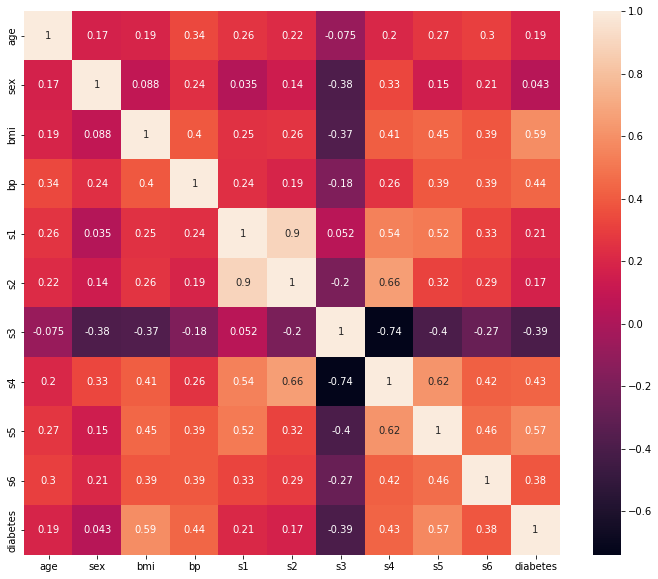

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using Pearson Correlation
plt.figure(figsize=(12,10))
correlation = data_df.corr()
sns.heatmap(correlation, annot=True)
plt.show()

Como podemos ver en el gráfico, los colores más claros representan correlaciones lineales muy fuertes y los colores más oscuros son representan las correlaciones lineales negativas más fuertes. Como se puede observar cada atributo tiene una correlación positiva total consigo mismo.
 
A continuación vamos a escoger los atributos que tengan la correlación más fuerte con la variables objetivo. En este caso escogeremos los atributos que tengan un valor absoluto mayor que 0.5 en su correlación con la variables objetivo.

In [9]:
# Correlation with output variable
correlation_target = abs(correlation['diabetes'])
# Selecting highly correlated features
relevant_features = correlation_target[correlation_target > 0.5]
# Dropping the target value
relevant_features = relevant_features.drop('diabetes')
# Sorting from more relevant to less relevant
relevant_features = relevant_features.sort_values(ascending=False)
relevant_features

bmi    0.586450
s5     0.565883
Name: diabetes, dtype: float64

También podríamos eliminar más atributos si estos atributos tuviesen una correlación muy alta entre ellas. Pero como podemos ver, en este caso la correlación entre las variables que hemos escogido no es demasiado fuerte.

In [10]:
print(data_df[['bmi', 's5']].corr())

          bmi        s5
bmi  1.000000  0.446159
s5   0.446159  1.000000


## Embedded

Métodos iterativos que automáticamente seleccionan
aquellos atributos que afectan más a la variable objetivo durante el entrenamiento. Los métodos más utilizados suelen ser métodos de regularización, que dándoles umbrales de coeficientes, penalizan los atributos.


### Regularización Lasso

En este caso, haremos la selección de atributos utilizando la regularización de Lasso.

Esta regularización penaliza los coeficientes de los atributos irrelevantes y los convierte en 0, y como los atributos con coeficiente 0 no aportan nada, estas se eliminan.
 
Tiene una capacidad de selección de atributos muy potente que se puede usar en diferentes situaciones. Sin embargo, también tiene algunos inconvenientes, por ejemplo, si la relación entre los atributos y la variable objetivo no es lineal, es posible que no sea una buena idea utilizar este tipo de métodos, ya que crean modelos lineales. Un análisis exploratorio de los datos puede ayudarnos a comprender mejor las relaciones más importantes entre los atributos y la variable objetivo, lo que nos permite seleccionar el mejor modelo para cada caso.

La idea de la regularización Lasso para la selección de atributos es muy simple, ajustamos el modelo a una versión escalada de nuestro dataset y escogemos las variables que tengan el coeficiente mayor a 0.

Importamos las librerías que vamos a utilizar.

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

Creamos un pipeline que estandariza los datos y crea un modelo Lasso.

In [12]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

Ahora tenemos que optimizar el hiperparámetro alfa de Lasso. Esta vez, vamos a probar varios valores de 0,1 a 10 con un paso de 0,1. Usaremos una validación cruzada para calcular el error cuadrático medio de cada valor de alfa, y seleccionamos el valor de alfa con menor error.

In [13]:
search = GridSearchCV(pipeline, 
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error"
                      )

En este caso, usamos el valor negativo del error cuadrático medio, es decir le agregaremos un signo negativo, porque el GridSearchCV intenta maximizar las métricas de rendimiento, y lo que queremos es minimizar el error cuadrático medio.

Entrenamos el modelo.

In [14]:
search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error')

Una vez que hemos ajustado el modelo podemos ver cuál ha sido el valor óptimo del hiperparámetro alfa.

In [15]:
search.best_params_

{'model__alpha': 2.3000000000000003}

También podemos ver los coeficientes obtenidos para cada atributo, que es lo que realmente nos interesa.

In [16]:
coefficients = search.best_estimator_.named_steps['model'].coef_
coef = pd.Series(coefficients, index = columns)

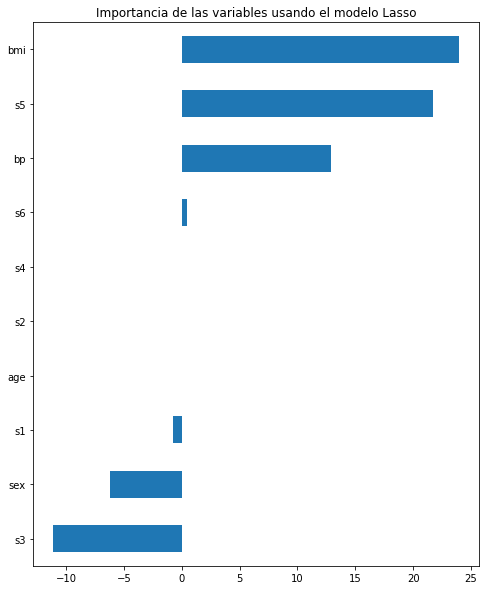

In [17]:
import matplotlib

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las variables usando el modelo Lasso")
plt.show()

Obtenemos los valores absolutos de los coeficientes, y mostramos cuales van a ser los atributos con los que nos quedaremos.

In [18]:
importance = np.abs(coefficients)

print('Atributos importantes:', np.array(columns)[importance > 0])
print('Atributos descartados:', np.array(columns)[importance == 0])

Atributos importantes: ['sex' 'bmi' 'bp' 's1' 's3' 's5' 's6']
Atributos descartados: ['age' 's2' 's4']
